# Machine Learning 과정
- 문제정의
- 데이터 수집
- 데이터 전처리 (인코딩,특성공학)
- 탐색적 데이터 분석 (시각화, 특성선택)
- 모델 선택 및 학습
- 하이퍼파라미터 튜닝 (교차검증,그리드서치)
- 모델 평가

In [1]:
%matplotlib inline

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_csv('./train.csv')

In [3]:
data.shape

(891, 12)

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 데이터 사전
- PassengerId : 탑승객 id
- Survived : 생존여부 (0 = 사망, 1 = 생존)
- Pclass : 티켓 클래스 (1등급, 2등급, 3등급)
- Name : 이름
- Sex : 성별 (male = 남성, female = 여성)
- Age : 나이
- SibSp : 형제/배우자의 수
- Parch : 부모/자녀 수
- Ticket : 티켓 번호
- Fare : 요금
- Cabin : 객실번호
- Embarked : 승선항 C = 쉘 부르그, Q = 퀸즈타운, S = 사우스 햄튼

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


비어있는 나이는 중간 값으로 채우자 (중간 값으로 하면 이상치에 대해 보완가능)

In [6]:
data['Age'] = data['Age'].fillna(data['Age'].median())

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


시각화 편의를 위해 Died 컬럼 추가

In [8]:
data['Died'] = 1 - data['Survived']

### 성별과의 관계

In [9]:
data.groupby('Sex').sum()[['Survived', 'Died']]

,Survived,Died
Sex,,
female,233,81
male,109,468


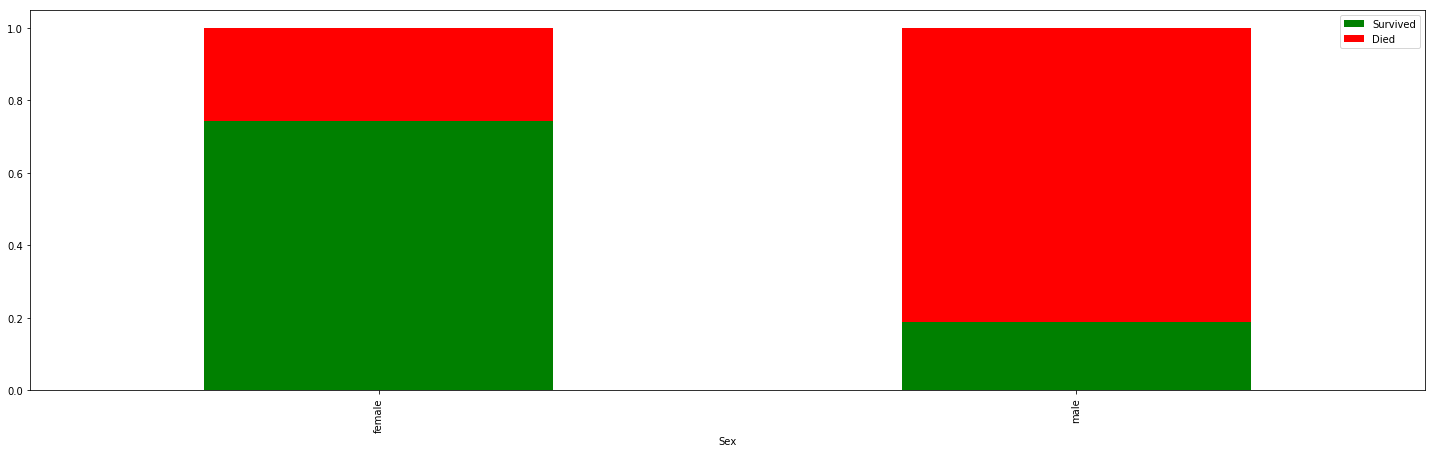

In [10]:
data.groupby('Sex').mean()[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7), 
                                                           stacked=True, color=['g', 'r']);

남성이 많이 죽고 여성이 많이 살았다. (성별 컬럼은 생존과 관계가 많다)

### 나이와의 관계

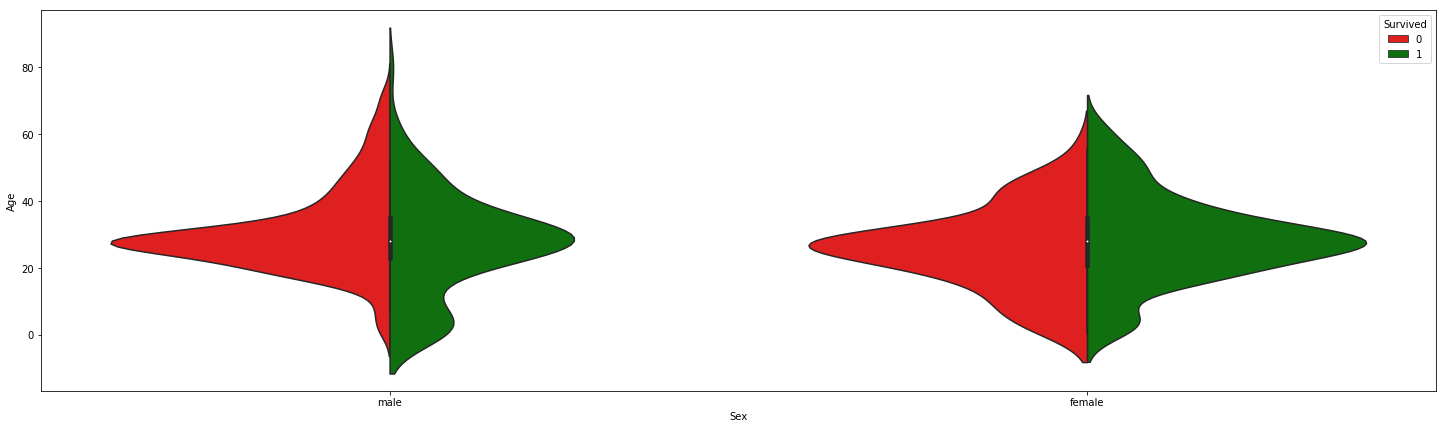

In [11]:
fig = plt.figure(figsize=(25, 7)) #그림 크기 지정
sns.violinplot(x='Sex', y='Age', #바이올린 그래프
               hue='Survived', data=data, 
               split=True,
               palette={0: "r", 1: "g"}
              );

- 남성 탑승객중 어린아이들이 조금 더 많이 살았다.
- 20~40 탑승객(남,여 모두)이 많이 사망했다.

### 요금과의 관계

C:\Users\eg00\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


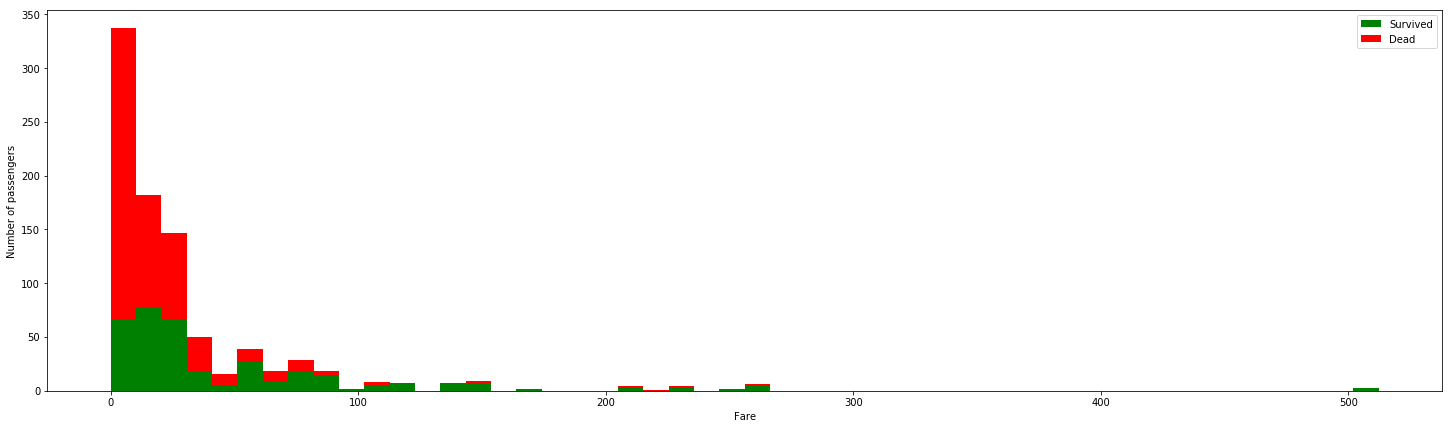

In [12]:
figure = plt.figure(figsize=(25, 7))
plt.hist([data[data['Survived'] == 1]['Fare'], data[data['Survived'] == 0]['Fare']], 
         stacked=True, color = ['g','r'],
         bins = 50, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend();

티켓 요금이 낮으면 많이 죽었다.

### 티켓요금과 선실등급과의 관계

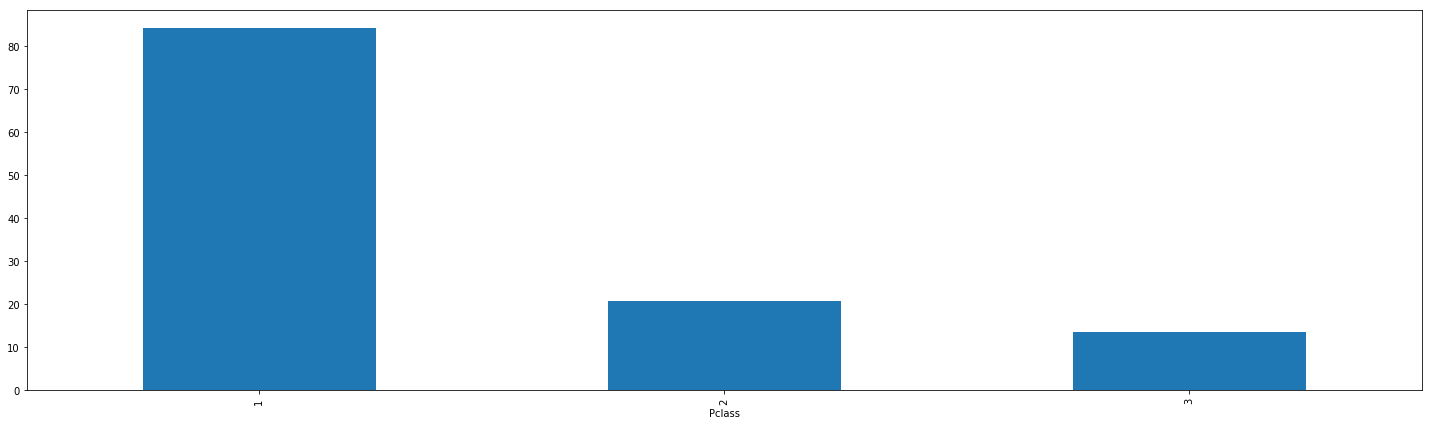

In [13]:
data.groupby('Pclass').mean()['Fare'].plot(kind='bar', figsize=(25, 7))

선실등급이 낮을 수록 티켓 가격이 싸다

### 승선항과의 관계

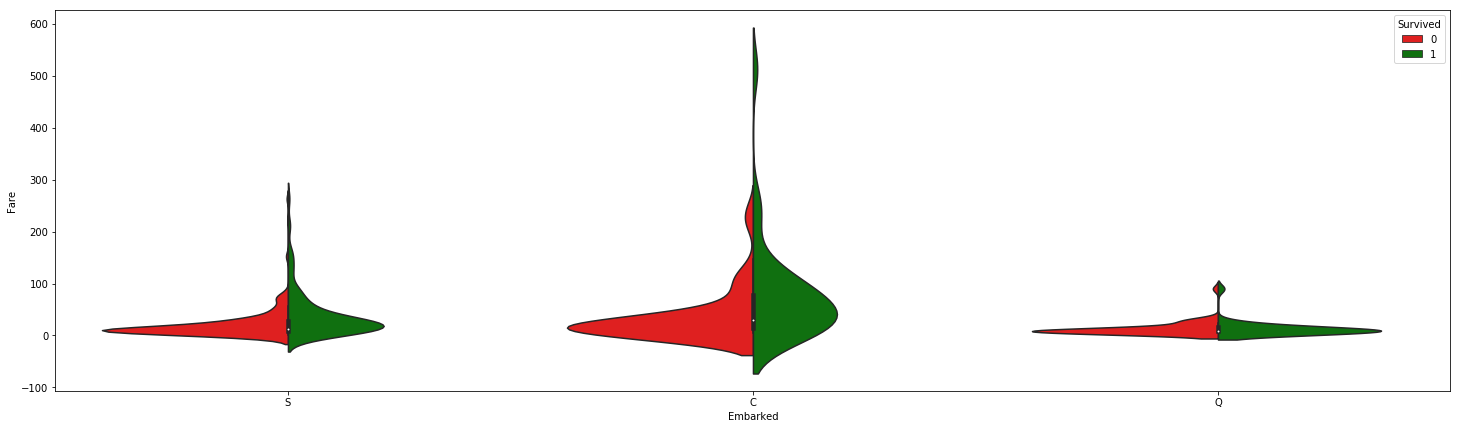

In [14]:
fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='Embarked', y='Fare', hue='Survived', data=data, split=True, palette={0: "r", 1: "g"});

- C,S는 요금 폭이 넓다
- 요금이 높은 사람들은 거의 죽지 않았다.

# Feature engineering

###  데이터로드
train과 test를 병합해서 사용

In [15]:
    # train,test 데이터 로드
    train = pd.read_csv('./train.csv')    
    test = pd.read_csv('./test.csv')

    # 생존여부를 별도로 분리
    # inplace 속성으로 drop결과를 바로 적용
    targets = train.Survived
    train.drop(['Survived'], axis = 1, inplace=True)
    
    # 두 개의 데이터 병합
    # ignore_index 속성으로 train,test의 인덱스를 순차적으로 만듬
    combined = train.append(test,ignore_index=True)
    
    # PassengerId는 삭제
    combined.drop(['PassengerId'], 1, inplace=True)
    combined

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [16]:
combined.shape

(1309, 10)

In [17]:
combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 탑승객 호칭 처리

- Braund, <b> Mr.</b> Owen Harris	
- Heikkinen, <b>Miss.</b> Laina
- Oliva y Ocana, <b>Dona.</b> Fermina (귀부인)
- Peter, <b>Master.</b> Michael J (도련님)

In [18]:
def split_title(x):
    return x.split(',')[1].split('.')[0].strip()

In [19]:
titles = data["Name"].apply(split_title).unique()
titles

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

몇 개의 타이틀로 정리

- Officer (장교)
- Royalty (귀족)
- Mr
- Mrs
- Miss
- Master

In [20]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

In [21]:
combined['Title'] = combined["Name"].apply(split_title)
#map함수를 통해 딕셔너리의 키 값과 시리즈의 인덱스 값이 같은 데이터를 찾아 변경
combined['Title'] = combined.Title.map(Title_Dictionary)

In [22]:
combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


### 나이 처리

- 시각화를 위해 중간 값으로 단순히 처리했지만, 좀 더 세분화 해서 나이를 채워보자
- 성별,선실등급,호칭으로 묶어서 평균나이를 구해보자

In [23]:
# as_index 속성으로 그룹을 묶는 컬럼을 인덱스에서 제외하자
grouped_train = combined.iloc[:891].groupby(['Sex','Pclass','Title'],as_index = False)
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train[['Sex', 'Pclass', 'Title', 'Age']]
grouped_median_train

,Sex,Pclass,Title,Age
0,female,1,Miss,30.0
1,female,1,Mrs,40.0
2,female,1,Officer,49.0
3,female,1,Royalty,40.5
4,female,2,Miss,24.0
5,female,2,Mrs,31.5
6,female,3,Miss,18.0
7,female,3,Mrs,31.0
8,male,1,Master,4.0
9,male,1,Mr,40.0


성별과 선실등급 그리고 호칭에 따라 평균 나이가 조금씩 다르다.

In [24]:
def fill_age(row):
    condition = (
            (grouped_median_train['Sex'] == row['Sex']) & 
            (grouped_median_train['Title'] == row['Title']) & 
            (grouped_median_train['Pclass'] == row['Pclass'])
        ) 
    if np.isnan(row['Age']): 
        return grouped_median_train[condition]['Age'].values[0]
    else :
        return row['Age']

In [25]:
combined['Age'] = combined.apply(fill_age, axis=1)

### 이름 처리
- 이름 특성 삭제
- 카테고리화 되어있는 호칭을 Model이 계산 할 수 있도록 one-hot-encoding

In [26]:
#이름 특성 삭제
combined.drop('Name', axis=1, inplace=True)

In [27]:
titles_dummies = pd.get_dummies(combined['Title'], prefix='Title')
titles_dummies.head()

,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


In [28]:
combined = pd.concat([combined, titles_dummies], axis=1)
combined.drop('Title', axis=1, inplace=True)

In [29]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0,0
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0,0
3,1,female,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,0,0
4,3,male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,0,0


### 요금 처리

In [30]:
combined.Fare.fillna(combined.Fare.mean(), inplace=True)

### 승선항 처리

- 결측치는 많은 사람들이 탑승한 S로 채운다
- encoding

In [31]:
combined.iloc[:891].Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [32]:
# 결측치 처리
combined.Embarked.fillna('S', inplace=True)
    
# one-hot-encoding
embarked_dummies = pd.get_dummies(combined['Embarked'], prefix='Embarked')
combined = pd.concat([combined, embarked_dummies], axis=1)

# 승선항 특성 삭제
combined.drop('Embarked', axis=1, inplace=True)

In [33]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,0,0,0,0,0,1
1,1,female,38.0,1,0,PC 17599,71.2833,C85,0,0,0,1,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,0,0,0,0,0,0,1
3,1,female,35.0,1,0,113803,53.1000,C123,0,0,0,1,0,0,0,0,1
4,3,male,35.0,0,0,373450,8.0500,NaN,0,0,1,0,0,0,0,0,1


### 객실번호 
- 결측치는 U(Uknown)로 대체
- 숫자를 제거한 맨 앞 글자로 변경
- encoding

In [34]:
# 결측치는 U로 대체
combined['Cabin'].fillna('U',inplace=True)

In [35]:
# Cabin의 첫 글자로 변경
combined['Cabin'] = combined['Cabin'].str[0]

In [36]:
# one-hot-encoding
cabin_dummies = pd.get_dummies(combined['Cabin'], prefix='Cabin')    
combined = pd.concat([combined, cabin_dummies], axis=1)

# Cabin 특성 삭제
combined.drop('Cabin', axis=1, inplace=True)

In [37]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,3,male,22.0,1,0,A/5 21171,7.2500,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,1,female,38.0,1,0,PC 17599,71.2833,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,...,1,0,0,0,0,0,0,0,0,1
3,1,female,35.0,1,0,113803,53.1000,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,3,male,35.0,0,0,373450,8.0500,0,0,1,...,1,0,0,0,0,0,0,0,0,1


### 성별 처리

In [38]:
combined['Sex'] = combined['Sex'].map({'male':1, 'female':0})

남성은 1 여성은 0으로 변경

In [39]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,3,1,22.0,1,0,A/5 21171,7.2500,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,1,0,38.0,1,0,PC 17599,71.2833,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,0,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,...,1,0,0,0,0,0,0,0,0,1
3,1,0,35.0,1,0,113803,53.1000,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,3,1,35.0,0,0,373450,8.0500,0,0,1,...,1,0,0,0,0,0,0,0,0,1


### 객실등급 처리

In [40]:
# one-hot-encoding
pclass_dummies = pd.get_dummies(combined['Pclass'], prefix="Pclass")
combined = pd.concat([combined, pclass_dummies],axis=1)
    
# 객실등급 특성 삭제
combined.drop('Pclass',axis=1,inplace=True)

In [41]:
combined.head()

,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3
0,1,22.0,1,0,A/5 21171,7.2500,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
1,0,38.0,1,0,PC 17599,71.2833,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,0,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,35.0,1,0,113803,53.1000,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
4,1,35.0,0,0,373450,8.0500,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1


### 티켓 처리

In [42]:
def cleanTicket(ticket):
    # .과/를 없애준다.
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    # 공백 기준으로 자른다.
    ticket = ticket.split()
    print(ticket)
    # 자른 리스트의 각 항목의 양쪽 공백을 없애준다.
    ticket = map(lambda t : t.strip(), ticket)
    # 숫자가 아닌 것만 필터링해서 리스트로 만듬
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX' #티켓 글자가 없으면 XXX로 표시

In [43]:
combined['Ticket'] = combined['Ticket'].map(cleanTicket)
tickets_dummies = pd.get_dummies(combined['Ticket'], prefix='Ticket')
combined = pd.concat([combined, tickets_dummies], axis=1)
combined.drop('Ticket', inplace=True, axis=1)

['A5', '21171']
['PC', '17599']
['STONO2', '3101282']
['113803']
['373450']
['330877']
['17463']
['349909']
['347742']
['237736']
['PP', '9549']
['113783']
['A5', '2151']
['347082']
['350406']
['248706']
['382652']
['244373']
['345763']
['2649']
['239865']
['248698']
['330923']
['113788']
['349909']
['347077']
['2631']
['19950']
['330959']
['349216']
['PC', '17601']
['PC', '17569']
['335677']
['CA', '24579']
['PC', '17604']
['113789']
['2677']
['A5', '2152']
['345764']
['2651']
['7546']
['11668']
['349253']
['SCParis', '2123']
['330958']
['SCA4', '23567']
['370371']
['14311']
['2662']
['349237']
['3101295']
['A4', '39886']
['PC', '17572']
['2926']
['113509']
['19947']
['CA', '31026']
['2697']
['CA', '34651']
['CA', '2144']
['2669']
['113572']
['36973']
['347088']
['PC', '17605']
['2661']
['CA', '29395']
['SP', '3464']
['3101281']
['315151']
['CA', '33111']
['CA', '2144']
['SOC', '14879']
['2680']
['1601']
['348123']
['349208']
['374746']
['248738']
['364516']
['345767']
['345779']
['33

In [44]:
combined.head()

,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,1,22.0,1,0,7.2500,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,38.0,1,0,71.2833,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,26.0,0,0,7.9250,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,35.0,1,0,53.1000,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


### 가족관련 특성 처리
- 부모,자녀,배우자,형제 모두 합친 특성을 새롭게 만듬
- 가족 숫자에 따라 1인, 소규모 가족, 대규모 가족으로 구분

In [45]:
# 본인을 포함하여 모든 가족수 특성 생성
combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1

# map함수는 apply처럼 함수를 넣어서 사용가능
# lambda는 간단한 함수를 줄여서 쓰는 방식
combined['Singleton'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5 <= s else 0)

In [46]:
combined.head()

,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,FamilySize,Singleton,SmallFamily,LargeFamily
0,1,22.0,1,0,7.2500,0,0,1,0,0,...,0,0,0,0,0,0,2,0,1,0
1,0,38.0,1,0,71.2833,0,0,0,1,0,...,0,0,0,0,0,0,2,0,1,0
2,0,26.0,0,0,7.9250,0,1,0,0,0,...,1,0,0,0,0,0,1,1,0,0
3,0,35.0,1,0,53.1000,0,0,0,1,0,...,0,0,0,0,0,1,2,0,1,0
4,1,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,0


In [49]:
#modeling

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
#train 과 test 분리

In [72]:
combined.shape

(1309, 67)

In [51]:
train = combined.iloc[:891]
test = combined.iloc[891:]

In [52]:
#교차 검증 진행후 평균값 계산하는 함수
def cal_score(model,x,y,scoring="accuracy"):
    result = cross_val_score(model,x,y,cv=5, scoring=scoring)
    return np.mean(result)


In [53]:
clf = RandomForestClassifier(n_estimators=20)
clf.fit(train,targets)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [54]:
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True,inplace=True)
features.set_index('feature',inplace=True)

In [74]:
#features

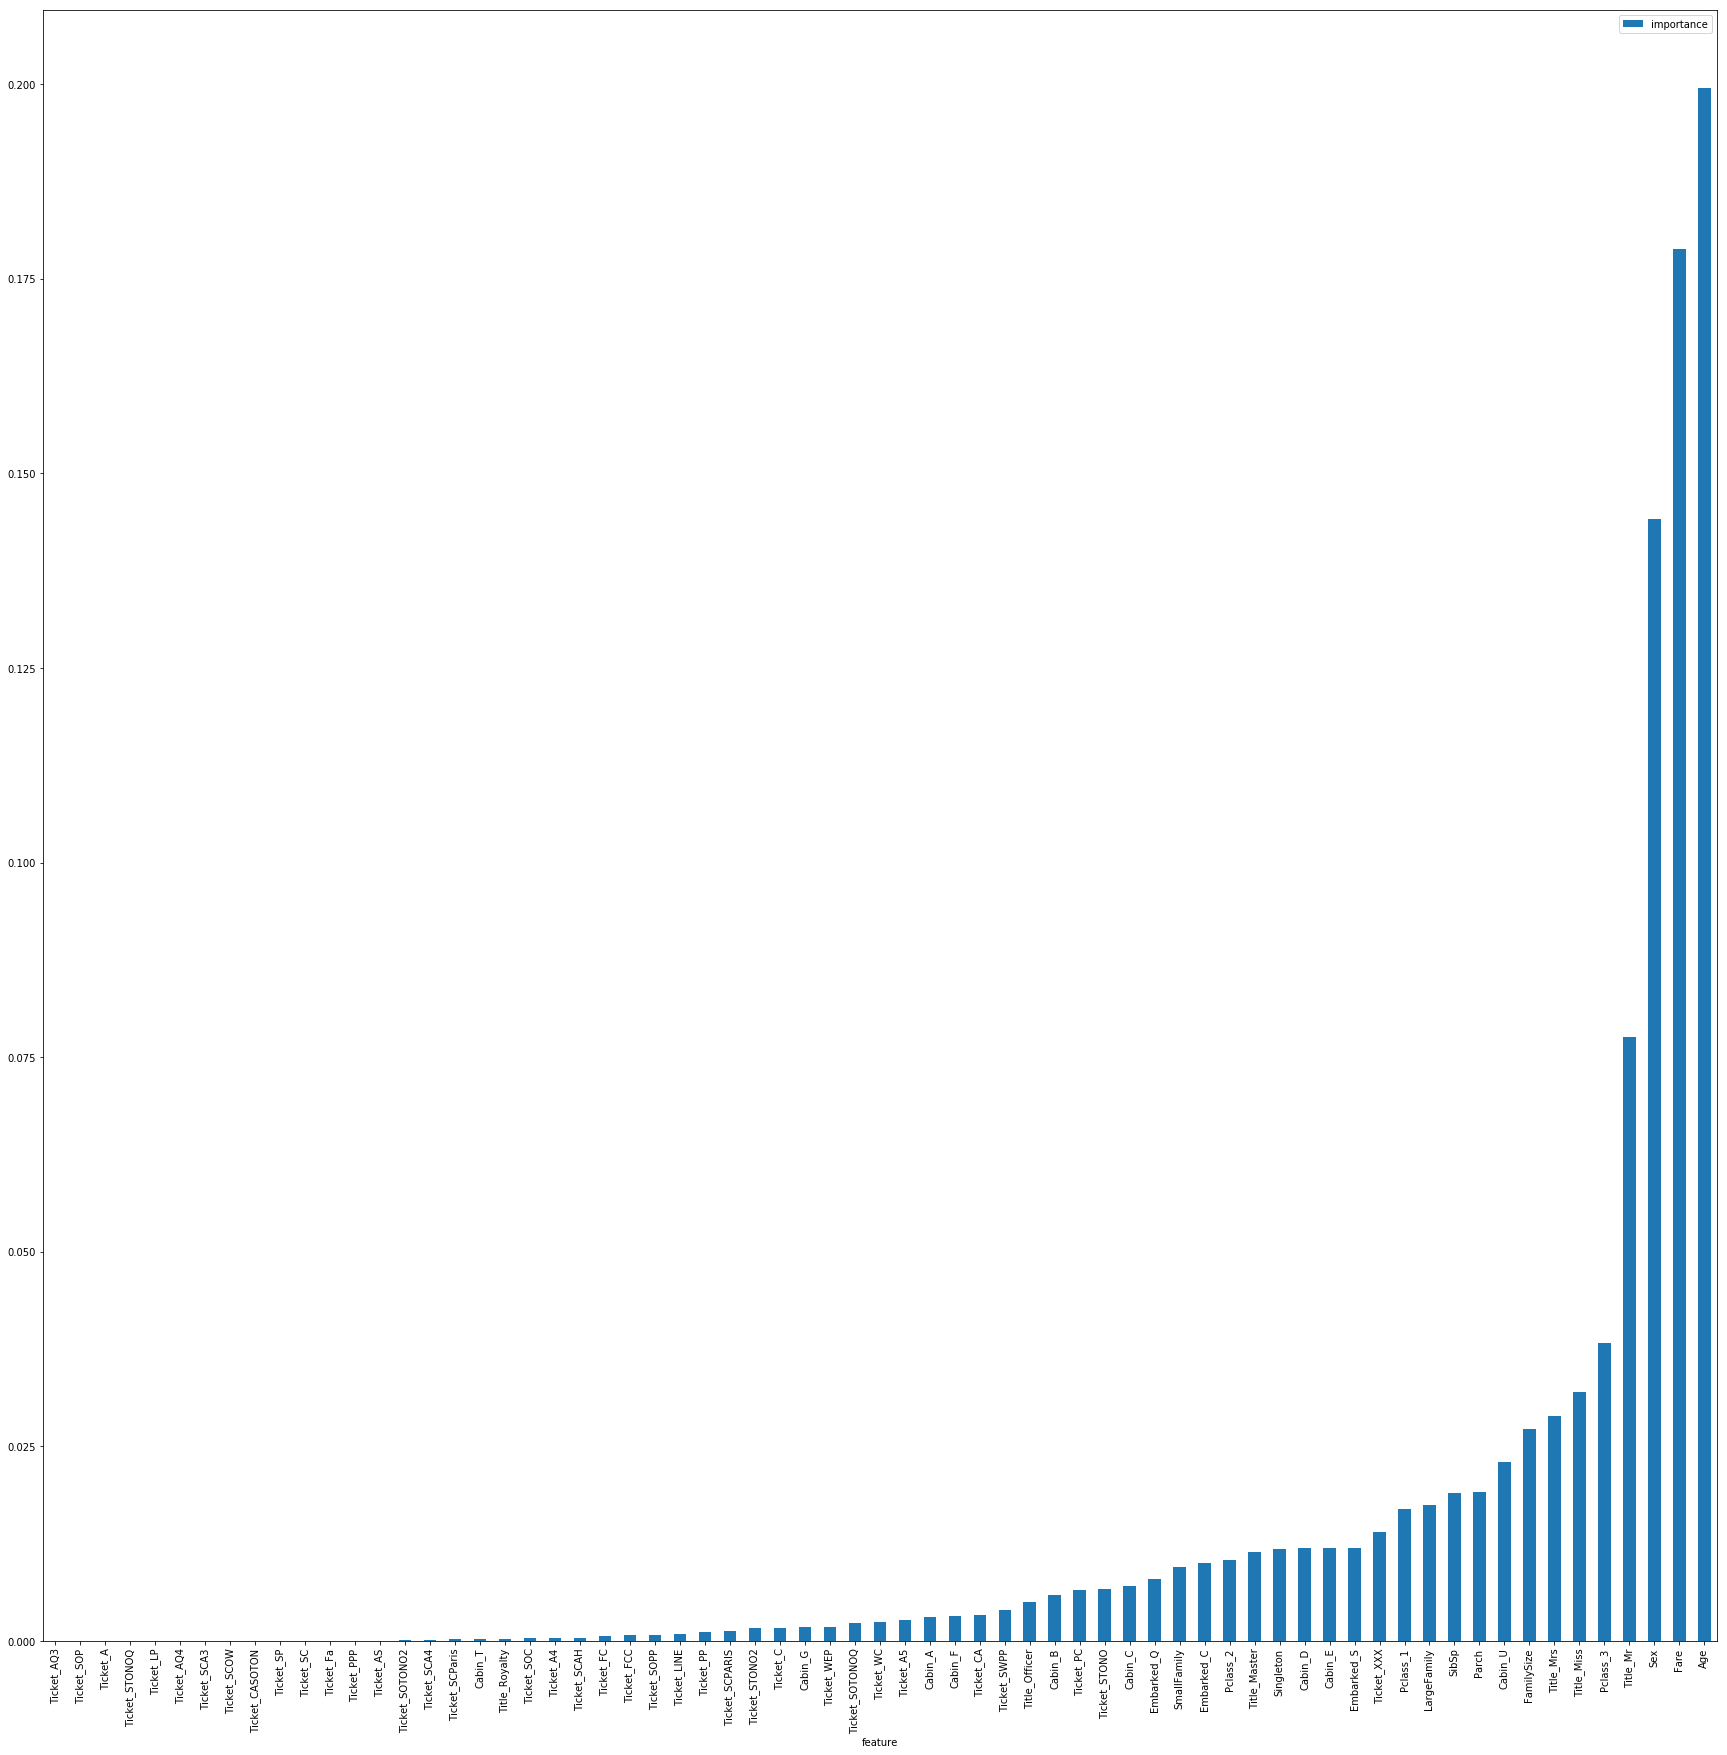

In [76]:
features.plot(kind="bar",figsize=(10,10))

In [59]:
cal_score(clf,train,targets)

0.80921867502758182

In [56]:
from sklearn.feature_selection import SelectFromModel

In [58]:
model = SelectFromModel(clf,prefit =True)
train_reduced = model.transform(train)

In [60]:
train_reduced.shape

(891, 13)

In [62]:
model2 = RandomForestClassifier(n_estimators=20)
cal_score(model2,train_reduced,targets)

0.811497393242823

In [63]:
model2.fit(train_reduced,targets)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [64]:
test_reduced = model.transform(test)
pre= model2.predict(test_reduced)

In [ ]:
#pre

In [ ]:
submission = pd.read_csv("gender_submission.csv")
submission["Survived"] =pre
submission.to_csv("mySubmission_1213.csv",index=False)

In [83]:
from sklearn.model_selection import GridSearchCV
m = RandomForestClassifier(random_state=7)
param_grid = {'max_depth':[3,5,7,9],
            'n_estimators':[10,30,50,100],
            'max_features':[0.2,0.4,0.6],
            'min_samples_leaf':[10,20,30]}
grid = GridSearchCV(m,param_grid,cv=5)
grid.fit(train_reduced,targets)
print("최상의 크로스 밸리데이션 점수:{: .2f}".format(grid.best_score_))
print("최적의 매개변수: ",grid.best_params_)

최상의 크로스 밸리데이션 점수: 0.83
최적의 매개변수:  {'max_depth': 9, 'max_features': 0.6, 'min_samples_leaf': 10, 'n_estimators': 30}
